In [33]:
import numpy as np 
import pandas as pd 
Data = pd.read_csv("cleaned_star_data.csv").dropna()
import optax
import matplotlib.pyplot as plt
from typing import List
import equinox as eqx
import jax
import jax.numpy as jnp
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

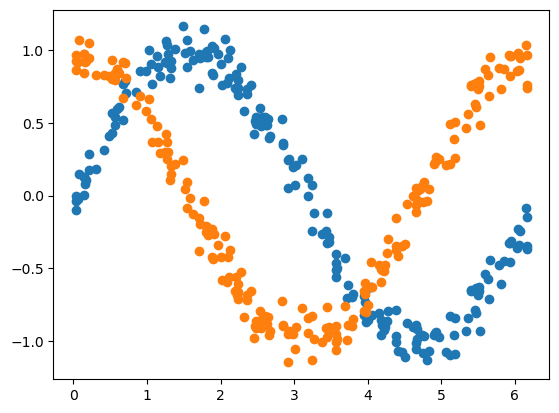

In [34]:
N_SAMPLES = 200
key, xkey, ynoisekey = jax.random.split(jax.random.PRNGKey(0), 3)
t_s = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2*jnp.pi).sort(axis = 0)
y_s = jnp.sin(t_s) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.1
z_s = jnp.cos(t_s) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.1
plt.scatter(t_s, y_s)
plt.scatter(t_s, z_s)


In [35]:
class LinearFunction(eqx.Module):
    layers: eqx.nn.MLP
    
    def __init__(self, key): 
        #print("DEBUG3")
        key1, key2, key3 = jax.random.split(key, 3)
        self.layers = eqx.nn.MLP(
            in_size=2,
            out_size=2,
            width_size=10,
            depth=3,
            activation=jnn.softplus,
            key=key1,
        )
    def __call__(self, t, y, args, **kwargs):
       return self.layers(y)


In [36]:
key = jax.random.PRNGKey(42)
x,y = jax.random.split(jax.random.PRNGKey(42), 2)
print(jax.random.split(key, 2)[0])
print(type(x))

[2465931498 3679230171]
<class 'jaxlib.xla_extension.ArrayImpl'>


In [37]:
initial = jnp.array([z_s[0], y_s[0]])

In [38]:
key = jax.random.PRNGKey(41)
key, subkey = jax.random.split(key, 2)
model2 =  LinearFunction(subkey)
initial = initial.reshape(2,)
initial



Array([ 0.9633299 , -0.00153659], dtype=float32)

In [39]:
t_s = t_s.reshape(len(t_s))

In [40]:
x = model2(t_s, initial, None)
print(type(x))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [41]:
"""solution = diffrax.diffeqsolve(diffrax.ODETerm(model2), diffrax.Tsit5(), t0 = t_s[0],  t1 = t_s[len(t_s-1)], dt0 = None,  y0 = jnp.array([0, 0]), 
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=t_s),"""
            

'solution = diffrax.diffeqsolve(diffrax.ODETerm(model2), diffrax.Tsit5(), t0 = t_s[0],  t1 = t_s[len(t_s-1)], dt0 = None,  y0 = jnp.array([0, 0]), \n            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),\n            saveat=diffrax.SaveAt(ts=t_s),'

In [42]:
"""sols = solution.ys[:199]
print(y_s[0:199].shape, sols[:, 0].shape)
y = sols[:, 0]
y =  np.nan_to_num(y, nan=0.0)
diffs = (y - y_s.reshape(200)[0:199])
sum(diffs)"""


'sols = solution.ys[:199]\nprint(y_s[0:199].shape, sols[:, 0].shape)\ny = sols[:, 0]\ny =  np.nan_to_num(y, nan=0.0)\ndiffs = (y - y_s.reshape(200)[0:199])\nsum(diffs)'

In [43]:
def model_to_loss(model, y_s, z_s, t_s):
    # Solve the differential equation
    if not jnp.all(t_s[1:] > t_s[:-1]):
        raise ValueError("t_s is not strictly increasing after sorting.")

    #print("Sorted t_s:", t_s)
    #print(t_s.shape)
    solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(model),
        diffrax.Tsit5(),
        t0=float(t_s[0]),
        t1=float(t_s[-1]),
        dt0=0.01,
        y0=jnp.array([0.0, 1.0], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(t_s)),
    )
    
    print(True)
    # Extract solutions for y and z
    y = solutions.ys[:N_SAMPLES-1, 0]
    z = solutions.ys[:N_SAMPLES-1, 1]

    
    # Use nan_to_num to handle NaNs
    y = jnp.nan_to_num(y, nan=0.0)
    z = jnp.nan_to_num(z, nan=0.0)

    # Calculate squared differences for the loss
    y_diff = (y - y_s[:N_SAMPLES-1]) ** 2
    z_diff = (z - z_s[:N_SAMPLES-1]) ** 2
   # print(jnp.mean(y_diff) + jnp.mean(z_diff))
    return jnp.mean(y_diff) + jnp.mean(z_diff)

In [44]:
model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)


In [45]:
opt = optax.sgd(0.05)  # Here you could also use optax.adam(...)
opt_state = opt.init(eqx.filter(model2, eqx.is_array))
y_s = y_s.reshape(N_SAMPLES)
Z_s = z_s.reshape(N_SAMPLES)

In [46]:
def make_step(m, opt_s, y_s, z_s, t_s):
    loss, grad = model_to_loss_and_grad(eqx.filter(m, eqx.is_inexact_array), y_s, z_s, t_s)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

loss_history = []
MODEL = LinearFunction(subkey)
for epoch in range(1000):
    MODEL, opt_state, loss = make_step(MODEL, opt_state, y_s, z_s, t_s)
    loss_history.append(loss)

    
    print(f"Epoch {epoch}, loss {loss}")

/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_50500/2925978858.py:14: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0.0, 1.0], dtype=jnp.float64),


TypeError: 'NoneType' object is not callable

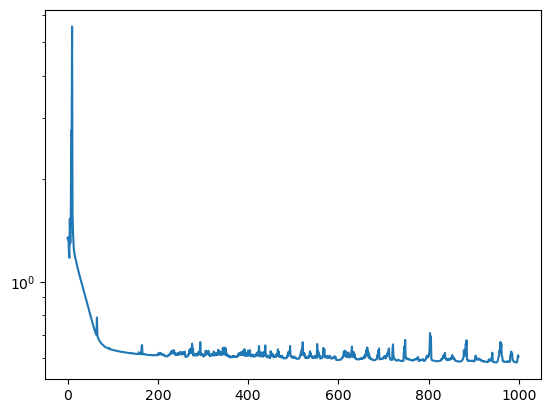

In [ ]:
plt.plot(loss_history)
plt.yscale('log')

In [ ]:
solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(MODEL),
        diffrax.Tsit5(),
        t0=float(t_s[0]),
        t1=float(t_s[-1]),
        dt0=0.01,
        y0=jnp.array([0.0, 1.0], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(t_s)),
    )
solutions.ys[:, 0]

/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_23641/2539220087.py:7: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0.0, 1.0], dtype=jnp.float64),


Array([ 0.        ,  0.00387617,  0.00690994,  0.03371203,  0.07097635,
        0.16806728,  0.16839048,  0.1706252 ,  0.1773568 ,  0.19738963,
        0.25197136,  0.2608238 ,  0.3849636 ,  0.51048315,  0.6000041 ,
        0.63244504,  0.63877404,  0.6758347 ,  0.68082803,  0.7001647 ,
        0.725526  ,  0.7694906 ,  0.76988196,  0.7822138 ,  0.7931124 ,
        0.85706306,  0.87797946,  0.89333725,  0.8994441 ,  0.9022094 ,
        0.9030208 ,  0.90339434,  0.90247977,  0.90140224,  0.89380807,
        0.8909173 ,  0.8889482 ,  0.8877039 ,  0.8860349 ,  0.88127357,
        0.87788475,  0.8762689 ,  0.8636495 ,  0.8255417 ,  0.8174576 ,
        0.8031353 ,  0.8027757 ,  0.7854633 ,  0.76646674,  0.72766376,
        0.72708994,  0.71911865,  0.68823415,  0.6765951 ,  0.67307454,
        0.6672604 ,  0.65687674,  0.6212606 ,  0.6184764 ,  0.6133422 ,
        0.6048284 ,  0.5640758 ,  0.54314274,  0.52620935,  0.5030753 ,
        0.4817397 ,  0.46618435,  0.46239048,  0.45201153,  0.39

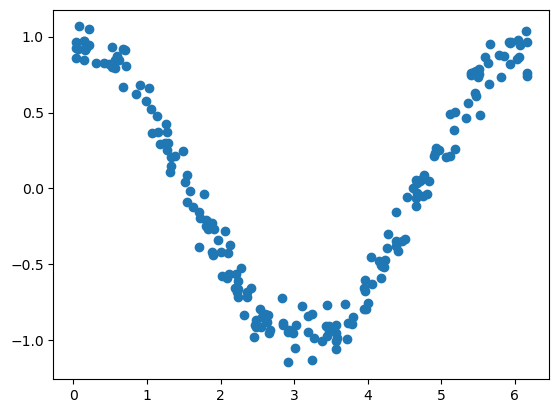

In [ ]:
plt.scatter(t_s, z_s)

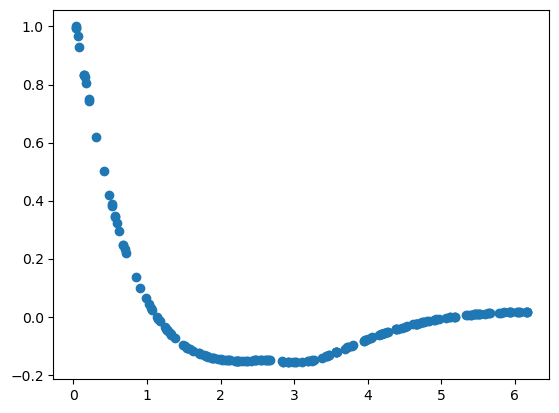

In [ ]:

plt.scatter(t_s,solutions.ys[:, 1])
